In [1]:
import stlearn as st

/home/mnik/miniconda3/envs/stlearn/lib/python3.8/site-packages/stlearn/tools/microenv/cci/het.py:192: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True, nopython=False)


In [2]:
data = st.Read10X(path="BCBA/V1_Breast_Cancer_Block_A_Section_1_spatial")

/home/mnik/miniconda3/envs/stlearn/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/mnik/miniconda3/envs/stlearn/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
data.shape

(3798, 36601)

In [4]:
data.obs

in_tissue  array_row  array_col     imagecol     imagerow
AAACAAGTATCTCCCA-1          1         50        102  1437.953781  1314.933980
AAACACCAATAACTGC-1          1         59         19   502.640259  1489.603946
AAACAGAGCGACTCCT-1          1         14         94  1349.092396   609.158410
AAACAGGGTCTATATT-1          1         47         13   435.478544  1254.290416
AAACAGTGTTCCTGGG-1          1         73         43   772.524745  1764.521435
...                       ...        ...        ...          ...          ...
TTGTTGTGTGTCAAGA-1          1         31         77  1157.013190   941.996690
TTGTTTCACATCCAGG-1          1         58         42   761.798672  1470.462032
TTGTTTCATTAGTCTA-1          1         60         30   626.485142  1509.405926
TTGTTTCCATACAACT-1          1         45         27   593.234318  1215.346522
TTGTTTGTGTAAATTC-1          1          7         51   865.016493   471.039599

[3798 rows x 5 columns]

In [5]:
st.settings.set_figure_params(dpi=120)
# Save raw_count
data.layers["raw_count"] = data.X
# Preprocessing
st.pp.filter_genes(data,min_cells=3)
st.pp.normalize_total(data)
st.pp.log1p(data)
# Keep raw data
data.raw = data
st.pp.scale(data)

Normalization step is finished in adata.X
Log transformation step is finished in adata.X
Scale step is finished in adata.X


In [6]:
data # st load

AnnData object with n_obs × n_vars = 3798 × 22240
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mean', 'std'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'
    layers: 'raw_count'

In [7]:
data.obsm['spatial']

array([[17428, 15937],
       [ 6092, 18054],
       [16351,  7383],
       ...,
       [ 7593, 18294],
       [ 7190, 14730],
       [10484,  5709]])

In [8]:
# Run PCA
st.em.run_pca(data,n_comps=50,random_state=0)

PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


In [9]:
data

AnnData object with n_obs × n_vars = 3798 × 22240
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mean', 'std'
    uns: 'spatial', 'log1p', 'pca'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'
    layers: 'raw_count'

In [10]:
len(data.obsm['X_pca'])

3798

In [11]:
# Tiling image
st.pp.tiling(data,out_path="tiling",crop_size = 40)

Tiling image: 100%|████████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]


In [12]:
# Using Deep Learning to extract feature
st.pp.extract_feature(data)
# Apply stSME spatial-PCA option
st.spatial.morphology.adjust(data,use_data="X_pca",radius=50,method="mean")
st.pp.neighbors(data,n_neighbors=25,use_rep='X_pca_morphology',random_state=0)

2024-11-26 17:03:40.864463: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-26 17:03:41.187812: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-11-26 17:03:41.187837: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-11-26 17:03:42.386863: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

The morphology feature is added to adata.obsm['X_morphology']!


Adjusting data: 100%|██████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]


The data adjusted by morphology is added to adata.obsm['X_pca_morphology']
Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 


Applying Louvain cluster ...
Louvain cluster is done! The labels are stored in adata.obs['louvain']


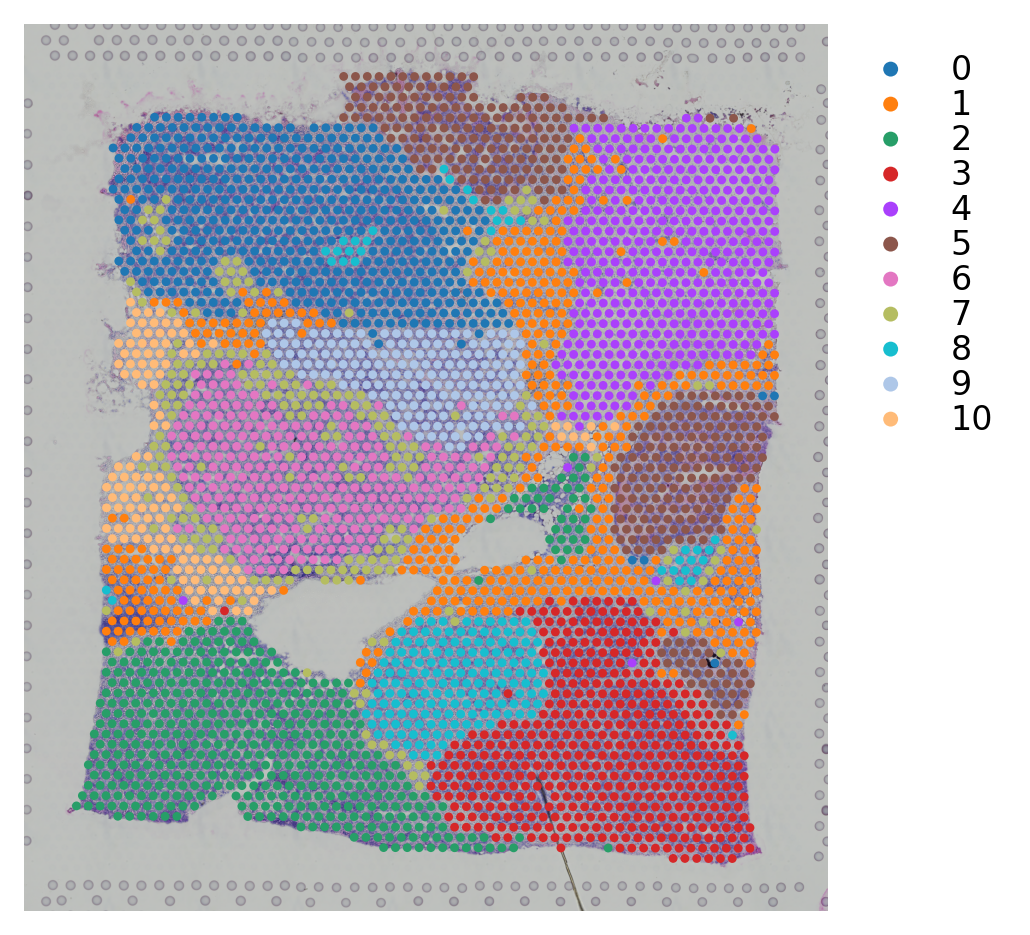

In [15]:
import scanpy as sc
st.tl.clustering.louvain(data,random_state=0,resolution=1.17)

# Generate enough colors for all clusters
n_clusters = len(data.obs['louvain'].unique())
data.uns['louvain_colors'] = sc.plotting.palettes.default_20[:n_clusters]

# Now try plotting
st.pl.cluster_plot(data, use_label="louvain", image_alpha=1, size=7)

In [14]:
data

AnnData object with n_obs × n_vars = 3798 × 22240
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'tile_path', 'louvain'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mean', 'std'
    uns: 'spatial', 'log1p', 'pca', 'neighbors', 'louvain', 'louvain_colors'
    obsm: 'spatial', 'X_pca', 'X_tile_feature', 'X_morphology', 'X_pca_morphology'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'distances', 'connectivities'

In [19]:
data.write_h5ad('stlearn_processed_data',compression='gzip')

In [16]:
import stlearn as st
import scanpy as sc

data = sc.read_h5ad("stlearn_processed_data")

In [17]:
data.uns["iroot"] = st.spatial.trajectory.set_root(data,use_label="louvain",cluster=6,use_raw=True)
st.spatial.trajectory.pseudotime(data,eps=50,use_rep="X_pca",use_label="louvain")

All available trajectory paths are stored in adata.uns['available_paths'] with length < 4 nodes


Start to construct the trajectory: 6 -> 5


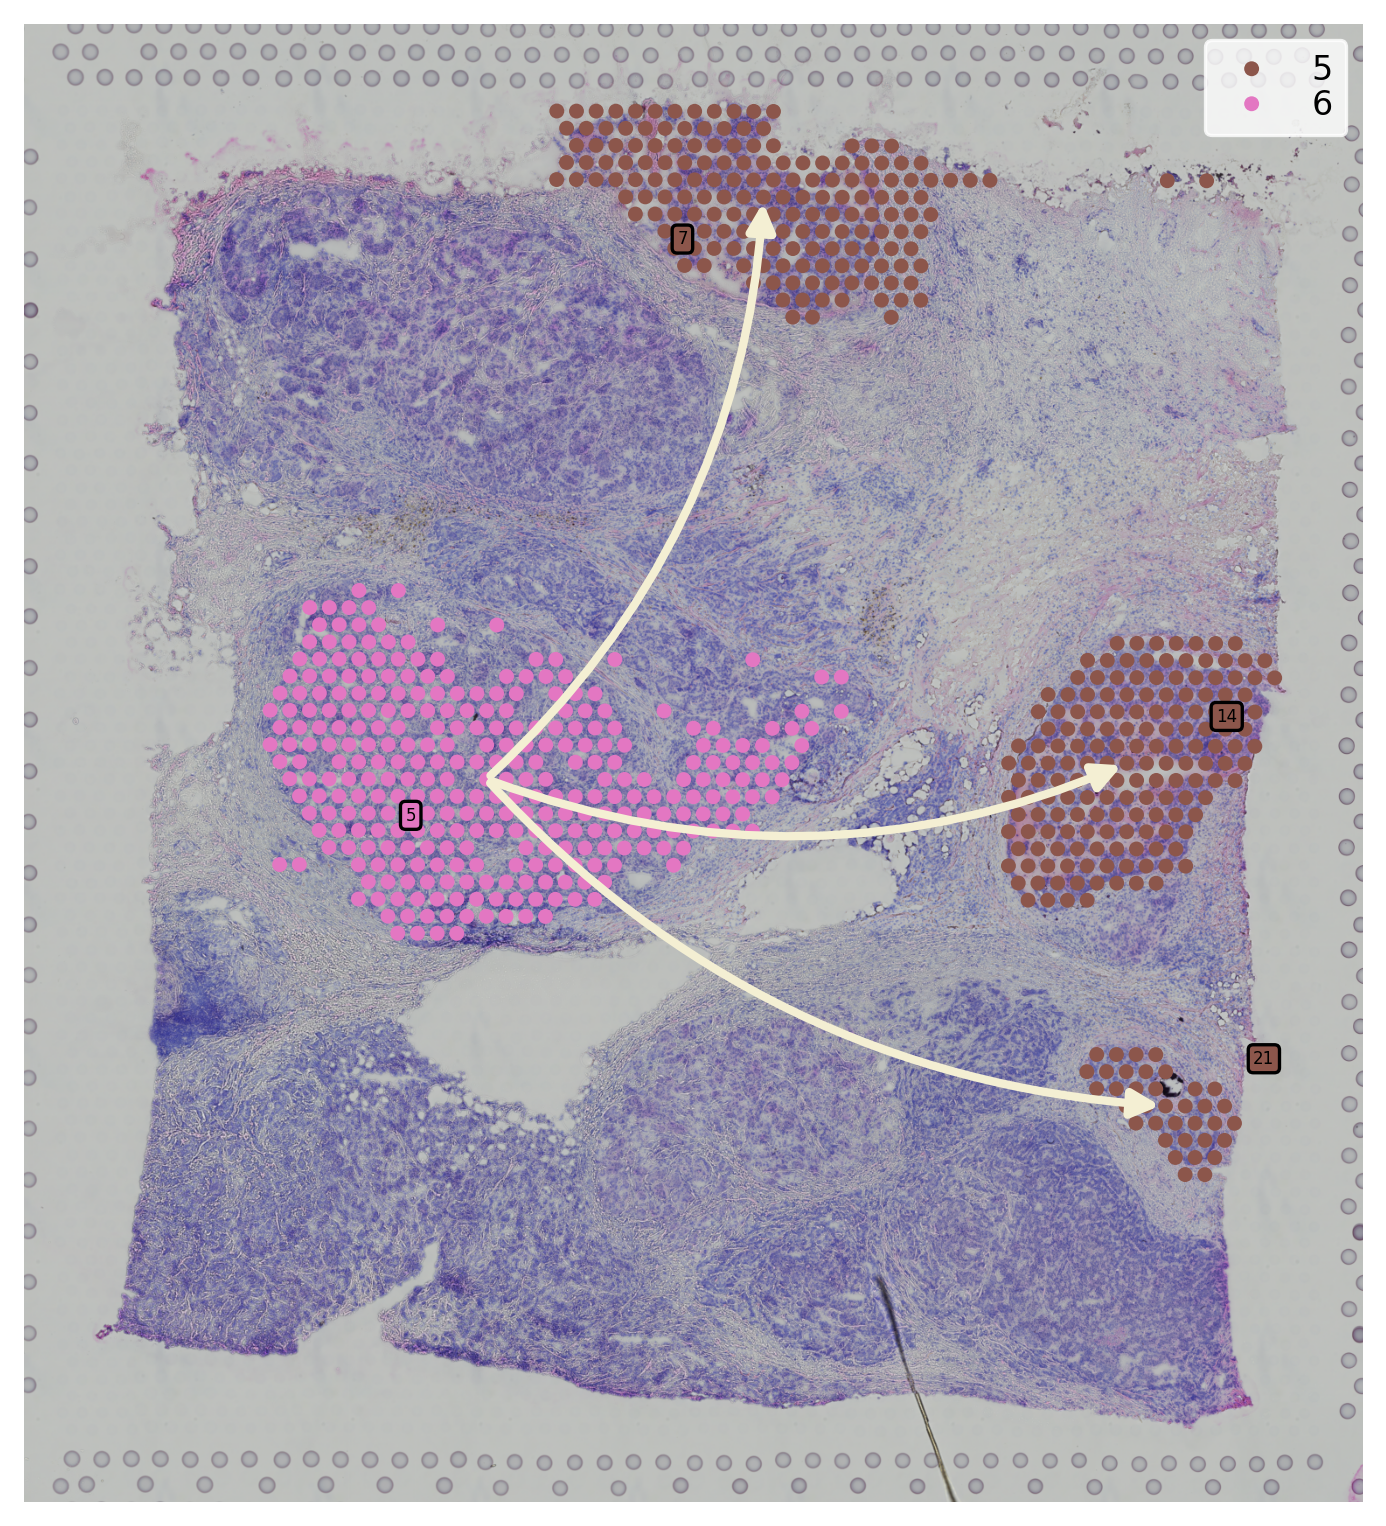

In [18]:
list_clusters = ["5", "6"]
st.spatial.trajectory.pseudotimespace_global(data,use_label="louvain",list_clusters=list_clusters)
st.pl.cluster_plot(data,use_label="louvain",show_trajectories=True,list_clusters=list_clusters,show_subcluster=True, figsize=(10,8), size=20)